<h1><center>Sartorius: Cell Instance Segmentation</center></h1>
                                                      
<center><img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS75MhDku1itW_qJxDfBwBywPP2ROhw0Vh9Dah3QllbkQW1h9gvBsQnWkScUikzJ7mvPJM&usqp=CAU" width = "750" height = "500"/></center>    

<h1><center>Load Modules</center></h1>

In [1]:
import os
import copy
import logging

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision

from torchvision.transforms import functional as F
#import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2

import albumentations as A
import albumentations.pytorch
from albumentations import (HorizontalFlip, VerticalFlip, 
                            ShiftScaleRotate, Normalize, Resize, 
                            Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2



import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import GPUtil
from GPUtil import showUtilization as gpu_usage

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from jupyterthemes import jtplot
import warnings

import time
from functools import wraps
import functools
import collections
import itertools

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.cuda.manual_seed_all(n)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(n)
    
set_random(42)

<h1><center>General Configurations</center></h1>

In [4]:
data_dir = './sartorius-cell-instance-segmentation'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 2
NUM_EPOCHS = 5
TRAIN_CSV = f"{data_dir}/train.csv"
TRAIN_PATH = f"{data_dir}/train"
TEST_PATH = f"{data_dir}/test"

WIDTH = 704
HEIGHT = 520
# Threshold for mask length
TH = 40
BATCH_SIZE = 2
LR = 1e-3
WEIGHT_DECAY = 0.0005


# Normalize to resnet mean and std if True.
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]
IMAGE_RESIZE = (224, 224)


WORKERS = 4

cmap = mpl.colors.ListedColormap(['black', 'gray', 'orange', 'green'])

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Load the data</center></h2>

In [5]:
train_files = sorted(list(Path(TRAIN_PATH).rglob('*png')))
test_files = sorted(list(Path(TEST_PATH).rglob('*.png')))
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


In [6]:
cell_df = pd.read_csv(TRAIN_CSV)
cell_df.info()
cell_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


id                                         annotation  width  \
65518  de504eaa5349  252178 6 252881 8 253585 9 254288 10 254992 11...    704   
48139  a76fe4d00355  112202 6 112905 10 113608 11 114314 9 115018 9...    704   
37042  836e5872684a  268741 3 269440 10 270138 18 270839 23 271544 ...    704   
60537  d09291445961  125348 8 126050 11 126753 13 127457 15 128162 ...    704   

       height cell_type plate_time sample_date  \
65518     520    shsy5y  11h30m00s  2019-06-15   
48139     520    shsy5y  11h30m00s  2019-06-14   
37042     520    shsy5y  11h30m00s  2019-06-14   
60537     520     astro  09h00m00s  2020-09-14   

                                sample_id elapsed_timedelta  
65518  shsy5y[diff]_D12-1_Vessel-714_Ph_2   0 days 11:30:00  
48139  shsy5y[diff]_E10-2_Vessel-714_Ph_3   0 days 11:30:00  
37042  shsy5y[diff]_D12-4_Vessel-714_Ph_4   0 days 11:30:00  
60537  astros[cereb]_F8-2_Vessel-361_Ph_4   0 days 09:00:00

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Utilits</center></h2>

***Run Length Encoding: Annotation Data to Mask Image¶***

This notebook refferred to INVERSION's notebook'Run Length Decoding - Quick Start'.

https://www.kaggle.com/inversion/run-length-decoding-quick-start


***What is Run-length encoding (RLE)?***

Run-length encoding (RLE) is a form of lossless data compression in which runs of data (sequences in which the same data value occurs   in many consecutive data elements) are stored as a single data value and count, rather than as the original run. This is most efficient on data that contains many such runs, for example, simple graphic images such as icons, line drawings, Conway's Game of Life, and animations. For files that do not have many runs, RLE could increase the file size. (from Wikipedia)

#### [WIKI](https://en.wikipedia.org/wiki/Run-length_encoding)

In [7]:
def rle_decode(mask_rle,shape,color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    if colors = 1, then:
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    # get starting pixel and cells's length
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -=1
    # Ending pixels
    ends = start + length
    img = np.zeros((shape[0] * shape[1], shape [2]), dtype=np.float32)
    for lo, hi in zip (start, ends):
        img[lo : hi] = color
    return img.reshape(shape)

Masks have an abnormally long continuous lines.

The mask is not representative enough.

We can take only correct masks to train our model.

**Thanks** [Slavko Prytula](https://www.kaggle.com/slavkoprytula/mask-correction-mask-filtering-updated#Utils)

In [8]:
def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

In [9]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    masks = np.zeros((height, width, 1))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle_decode(label, shape=(height,width, 1))
        a_mask = np.array(a_mask) > 0 
        a_mask, broken_mask = clean_mask(a_mask)
        if broken_mask:
            continue
        masks += a_mask
    masks = masks.clip(0,1)
    return masks

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize the Data</center></h2>

--- 0.002962350845336914 seconds in label ---
--- 0.017661571502685547 seconds in sorting df ---
--- 8.806761980056763 seconds in mask1 ---
--- 8.522104501724243 seconds in mask2 ---
0030fd0e6378


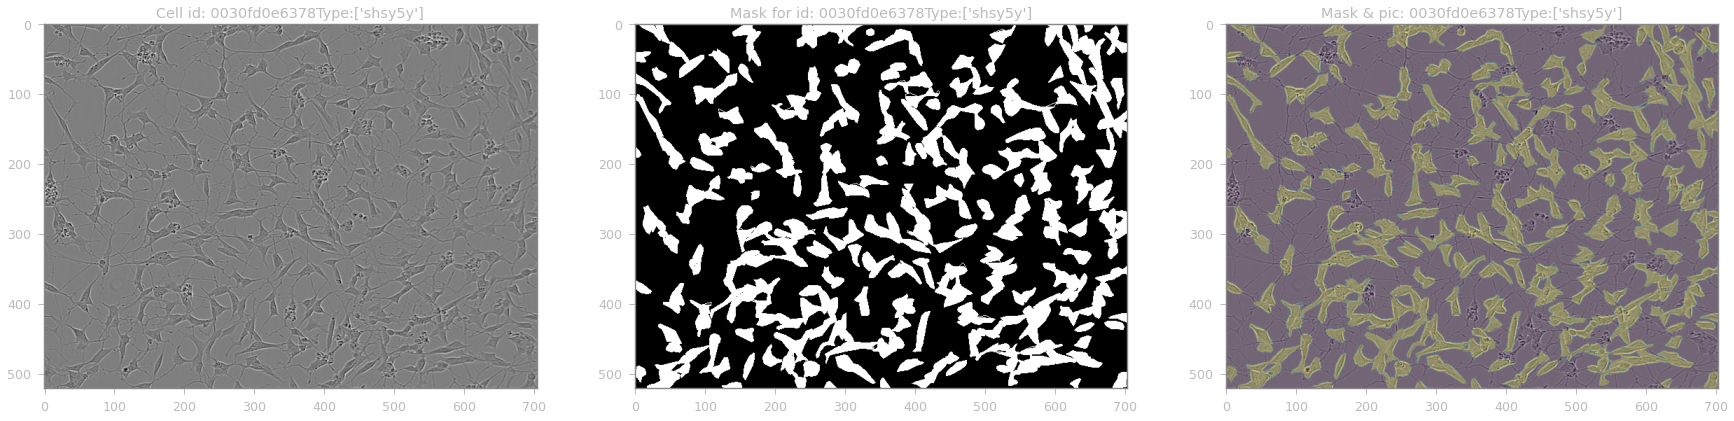

--- 0.0011551380157470703 seconds in label ---
--- 0.004678487777709961 seconds in sorting df ---
--- 1.9769752025604248 seconds in mask1 ---
--- 2.017040729522705 seconds in mask2 ---
0140b3c8f445


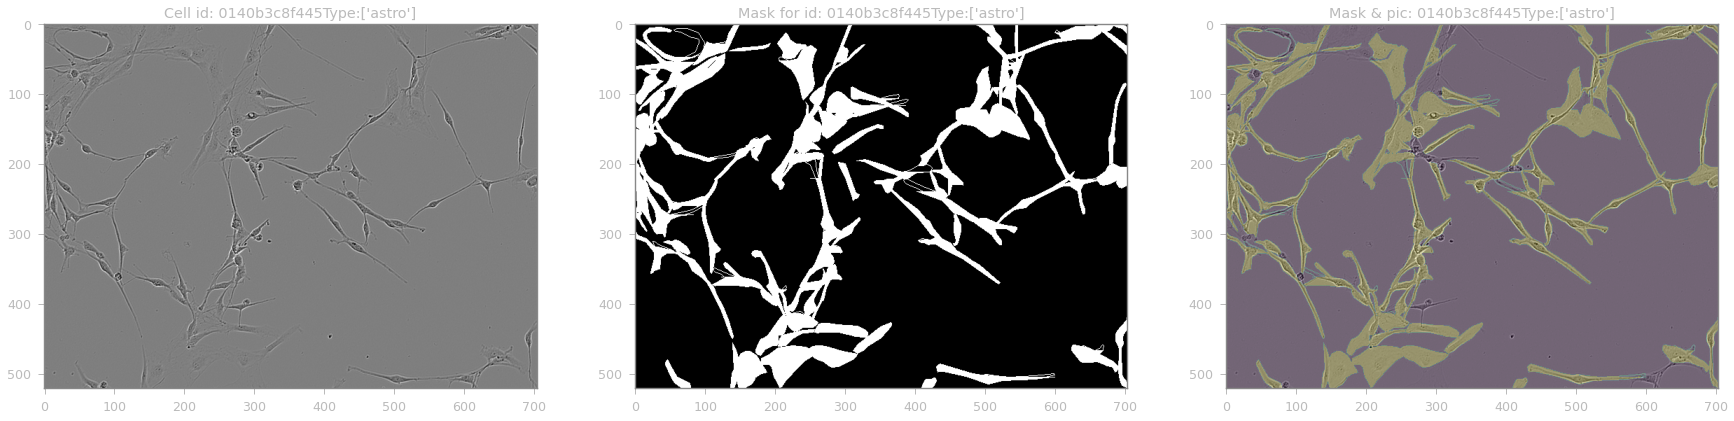

--- 0.0008108615875244141 seconds in label ---
--- 0.0049588680267333984 seconds in sorting df ---
--- 0.6692700386047363 seconds in mask1 ---
--- 0.6642892360687256 seconds in mask2 ---
01ae5a43a2ab


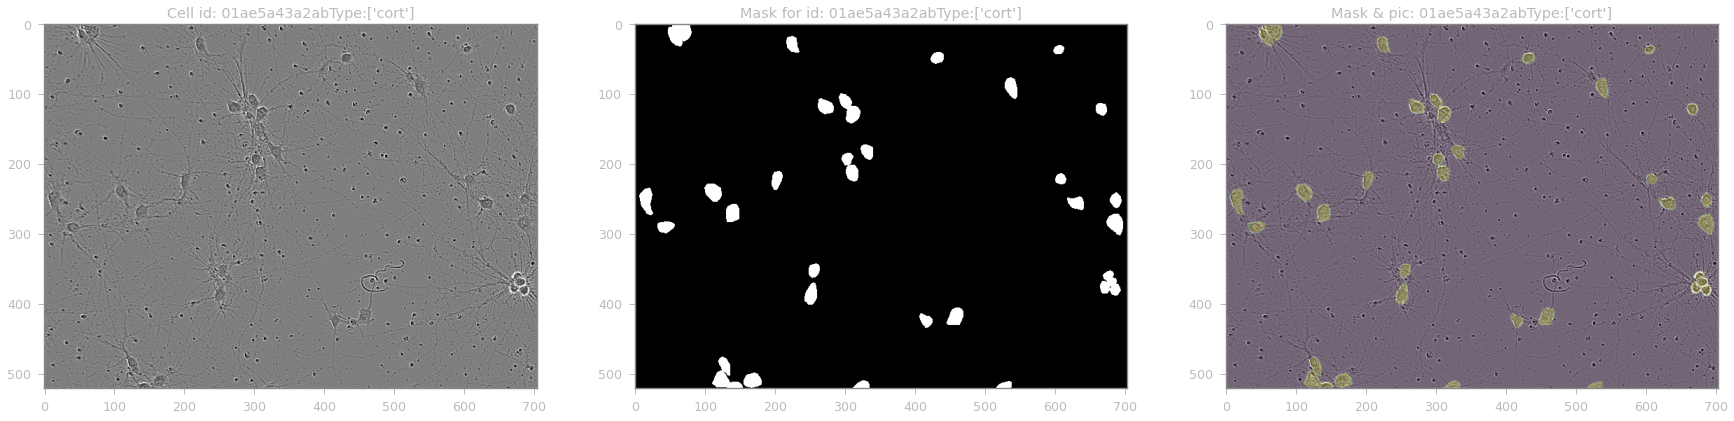

--- 0.00077056884765625 seconds in label ---
--- 0.005280494689941406 seconds in sorting df ---
--- 0.8031699657440186 seconds in mask1 ---
--- 0.783055305480957 seconds in mask2 ---
026b3c2c4b32


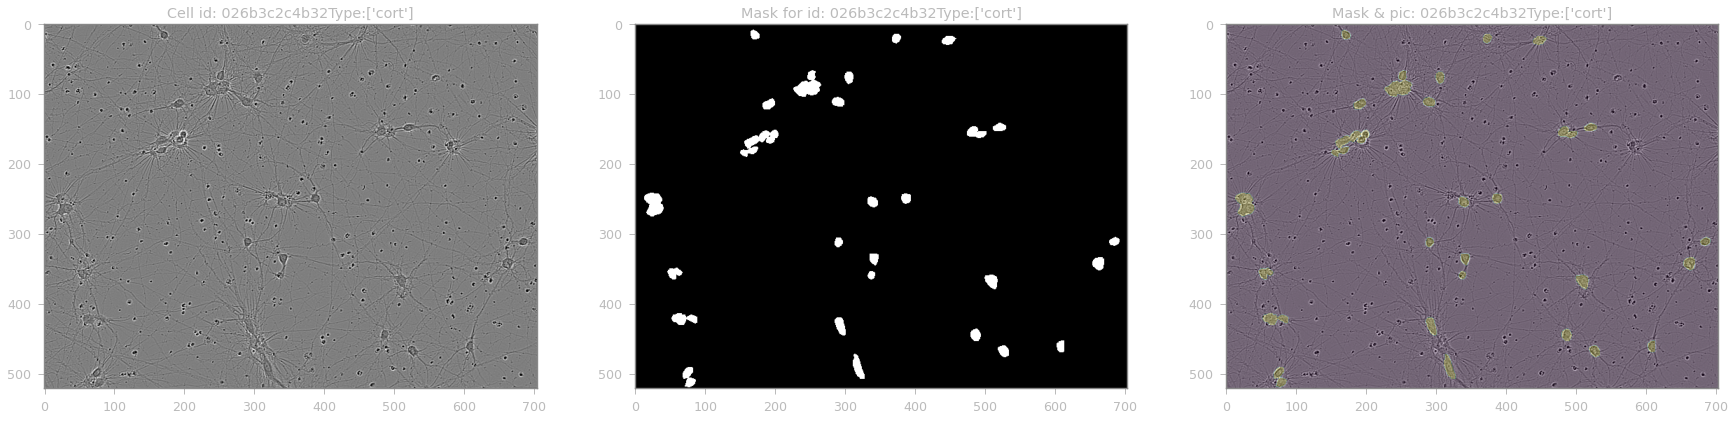

In [10]:
temp = cell_df.groupby(['id','cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
for i in range(4):
    #rand_idx = int(np.random.uniform(0, 607))
    #im = PIL.Image.open(train_files[rand_idx])
    im = PIL.Image.open(train_files[i])
    
    start = time.time()
    label = (train_files[i]).stem
    
    cell_type = temp[temp['id'] == label]
    cell_type = str(cell_type['cell_type'].values)
    print("--- %s seconds in label ---" % (time.time() - start))
    
    start = time.time()
    sample_im_df = cell_df[cell_df['id'] == label]
    print("--- %s seconds in sorting df ---" % (time.time() - start))
    
    sample_rles = sample_im_df['annotation'].values
    start = time.time()
    sample_masks1 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=False)
    print("--- %s seconds in mask1 ---" % (time.time() - start))
    
    start = time.time()
    sample_masks2 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=True)
    print("--- %s seconds in mask2 ---" % (time.time() - start))
    print(str(label))
    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20),)
    ax1.imshow(im,cmap='gray')
    ax2.imshow(sample_masks1, cmap='gray')
    ax3.imshow(im,cmap='gray')
    ax3.imshow(sample_masks2,alpha = .2)
    
    ax1.set_title('Cell id: ' + str(label) + 'Type:' + str(cell_type))
    ax2.set_title('Mask for id: ' + str(label) + 'Type:' + str(cell_type))
    ax3.set_title('Mask & pic: ' + str(label) + 'Type:' + str(cell_type))
    plt.show();
del temp, im, sample_masks1, sample_masks2

<h1><center>Preparing DataSets And DataLoaders</center></h1>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Define Augmenting</center></h2>

In [11]:
def get_augmentation(pic_size,mode):
    if mode !='train':
        augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
                                                    A.Normalize(
                                                        mean=RESNET_MEAN,
                                                        std=RESNET_STD),
                                                    A.pytorch.transforms.ToTensorV2()])
        return augmentation_test
    else:
        augmentation_train = A.Compose([
            A.Resize(pic_size,pic_size),
            A.RandomCrop(pic_size, pic_size),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                #A.VerticalFlip(p=0.5)
            ], p=0.5),
            A.OneOf([
                A.GaussNoise(),], p=0.8),

            A.OneOf([
                A.CLAHE(clip_limit=2),
                #A.RandomBrightnessContrast(),
            ], p=0.2),
#             A.HueSaturationValue(p=0.2),
            A.Normalize(
                mean=RESNET_MEAN,
                std=RESNET_STD),
            A.pytorch.transforms.ToTensorV2()], p=1)
        return augmentation_train

In [12]:
class NeuroDataSet(Dataset):
    def __init__(self, files, df: pd.core.frame.DataFrame,train:bool, transform=None):   
        self.files = files
        self.df = df
        #self.transform = transform
        self.height = HEIGHT
        self.width = WIDTH
        self.gb = self.df.groupby('id')
        self.transform = transform
        self.len_ = len(self.files)
        self.train = train
        
    
    def load_sample(self, file):
        img = cv2.imread(str(file), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self,index):
        # load image
        img, img_id = self.load_sample(self.files[index])
        df_temp = self.gb.get_group(img_id)
        
        annotations = df_temp['annotation'].values
        mask = build_mask(annotations, (self.height,self.width), colors=False)
        mask = mask.astype('float32')
        if self.transform is not None:
            augmented = self.transform(image = img, mask = mask)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
        else:
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))   
    def __len__(self):
        return self.len_

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Split train-val set</center></h2>

In [13]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.1)

In [14]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 545

Number of pictures in val set: 61


In [15]:
# split pandas dataframe with annotations for train df and val df
# in consistance with given file Ids
df_train = cell_df[(cell_df['id'].isin(train_pic_id))]
df_val = cell_df[(cell_df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 545

Number of picture's id in val set 61


In [16]:
train_dataset = NeuroDataSet(train_pics,
                             df_train,
                             train = True,
                             transform=get_augmentation(224, 'train')
                            )

In [17]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=WORKERS,)

In [18]:
val_dataset = NeuroDataSet(val_pics,
                           df_val,train=False,
                          transform=get_augmentation(224, 'val')
                          )

In [19]:
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=WORKERS,)

In [20]:
batch = next(iter(train_loader)) 
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")
del batch, images, masks

image shape: torch.Size([2, 3, 224, 224]),
mask shape:torch.Size([2, 1, 224, 224]),
batch len: 2


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize Augmented DataSet</center></h2>

In [21]:
def visualize_augmentations(dataset, idx=1, samples=9, cols=3):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, A.pytorch.ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i in range(samples):
        image, mask = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    del dataset

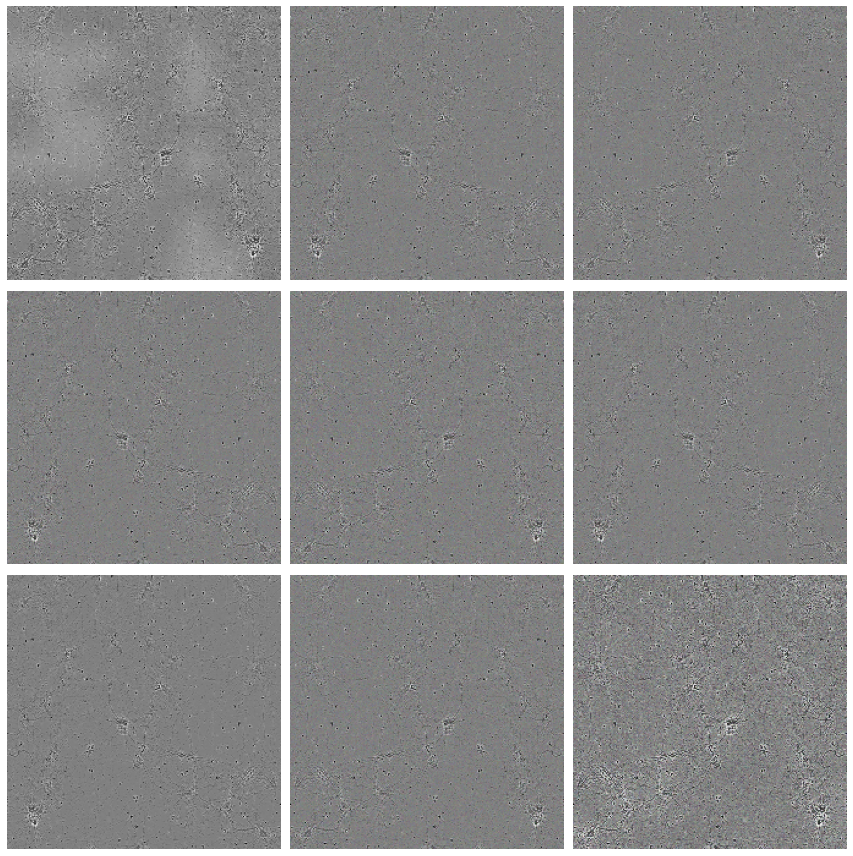

In [22]:
visualize_augmentations(train_dataset,idx=3)

In [23]:
# Create convolution block class
class Conv_Block(nn.Module):
    '''convolution ==> BN ==> ReLU'''
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [24]:
class Encoder(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Conv_Block(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = x.cuda()
        return self.maxpool_conv(x)

In [25]:
class Decoder(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = Conv_Block(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = x1.cuda()
        x2 = x2.cuda()
        x1 = self.up(x1)
#         # input CxHxW
#         diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
#         diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [26]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [27]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = Conv_Block(n_channels, 64)
        self.enc1 = Encoder(64, 128)
        self.enc2 = Encoder(128, 256)
        self.enc3 = Encoder(256, 512)
        self.enc4 = Encoder(512, 512)
        self.dec1 = Decoder(1024, 256, bilinear)
        self.dec2 = Decoder(512, 128, bilinear)
        self.dec3 = Decoder(256, 64, bilinear)
        self.dec4 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.outc(x)
        return logits

In [28]:
print(f"Initial GPU Usage at fit_epoch")
gpu_usage()

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 |  2% | 19% |


In [29]:
import segmentation_models_pytorch as smp
from Losses import ComboLoss, dice_metric

In [30]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary') 
Jaccard     = smp.losses.JaccardLoss(mode='binary', from_logits=False)
Dice        = smp.losses.DiceLoss(mode='binary',)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def criterion(y_pred, y_true):
    return JaccardLoss(y_pred, y_true)

In [31]:
def train_loop(model, optimizer, criterion, train_loader, device=DEVICE):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]  # += loss * current batch size
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    del imgs, masks
    torch.cuda.empty_cache()
    return running_loss

In [32]:
@torch.no_grad() #!!!!!!!!!!!!!!!!!!!!!!
def eval_loop(model, criterion, eval_loader, device=DEVICE):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}


In [33]:
@torch.no_grad()
def visualize_train(model,val_loader, device=DEVICE):
    model.eval()
    X_val, Y_val = next(iter(val_loader))
    Y_hat = model(X_val.to(device))
    
    Y_hat = torch.tanh(Y_hat)
    Y_hat = Y_hat.detach().cpu().numpy()
    X_val = X_val.detach().cpu().numpy()
    
    #clear_output(wait=True)
    for k in range(2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),)
        ax1.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3),cmap='gray')
        #ax1.imshow(np.rollaxis(X_val[k], 0, 3),cmap='gray')
        ax2.imshow(((Y_hat[k, 0] * 255)), cmap='gray')
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax1.set_title('Real')
        ax2.set_title('Output')
    plt.show()
    del X_val, Y_hat

In [34]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=DEVICE, 
          num_epochs=30, 
          valid_loss_min=np.inf,
          #logdir='logdir',
         vis=False,
         model_name=None):
    #step = 0
    history = []
       
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        torch.cuda.empty_cache() #!!!!!!!!!!!!!!!!!
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        history.append((train_loss,metrics["loss"],metrics["accuracy"],metrics["f1_macro"]))
        
        #writer = SummaryWriter(f"runs/Sartorius LR_{LR}_BS_{BATCH_SIZE}")
        # visualize model in tensorboard
        #images, masks = next(iter(train_loader))
        #writer.add_graph(model, images.to(device))
        #writer.close()
        
        if vis:
            visualize_train(model,val_loader,device=DEVICE)
        
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)


        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), model_name)
            valid_loss_min = metrics["loss"]
        #step +=1
    return history

In [35]:
model = UNet(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY )
criterion = BCELoss

In [36]:
history = train(model, optimizer, criterion, train_loader, val_loader, model_name='UNET_1_BCE.pt')

Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 1 TrainLoss: 0.28809 ValidLoss: 0.24273 ACC: 0.90083 F1: 0.301


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 2 TrainLoss: 0.25734 ValidLoss: 0.22540 ACC: 0.89809 F1: 0.105


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 3 TrainLoss: 0.24855 ValidLoss: 0.22034 ACC: 0.90444 F1: 0.248


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 4 TrainLoss: 0.24779 ValidLoss: 0.22512 ACC: 0.90195 F1: 0.208


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 5 TrainLoss: 0.24692 ValidLoss: 0.22751 ACC: 0.90985 F1: 0.352


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 6 TrainLoss: 0.24880 ValidLoss: 0.22052 ACC: 0.90371 F1: 0.232


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 7 TrainLoss: 0.24853 ValidLoss: 0.21726 ACC: 0.90083 F1: 0.147


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 8 TrainLoss: 0.24434 ValidLoss: 0.21729 ACC: 0.90714 F1: 0.320


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 9 TrainLoss: 0.24270 ValidLoss: 0.21580 ACC: 0.91181 F1: 0.362


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 10 TrainLoss: 0.23915 ValidLoss: 0.21147 ACC: 0.90228 F1: 0.193


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 11 TrainLoss: 0.23971 ValidLoss: 0.19339 ACC: 0.91783 F1: 0.426


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 12 TrainLoss: 0.23763 ValidLoss: 0.20904 ACC: 0.91803 F1: 0.449


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 13 TrainLoss: 0.23707 ValidLoss: 0.23213 ACC: 0.90498 F1: 0.245


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 14 TrainLoss: 0.23099 ValidLoss: 0.24315 ACC: 0.90730 F1: 0.319


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 15 TrainLoss: 0.23130 ValidLoss: 0.21523 ACC: 0.90242 F1: 0.187


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 16 TrainLoss: 0.22765 ValidLoss: 0.23132 ACC: 0.90652 F1: 0.266


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 17 TrainLoss: 0.22416 ValidLoss: 0.18316 ACC: 0.92064 F1: 0.419


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 18 TrainLoss: 0.22461 ValidLoss: 0.18100 ACC: 0.91938 F1: 0.404


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 19 TrainLoss: 0.22167 ValidLoss: 0.18431 ACC: 0.92879 F1: 0.541


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 20 TrainLoss: 0.22119 ValidLoss: 0.19175 ACC: 0.92484 F1: 0.486


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 21 TrainLoss: 0.21829 ValidLoss: 0.19715 ACC: 0.93162 F1: 0.550


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 22 TrainLoss: 0.21596 ValidLoss: 0.18342 ACC: 0.92481 F1: 0.482


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:57<00:00,  1.86s/it]


Epoch: 23 TrainLoss: 0.21404 ValidLoss: 0.19940 ACC: 0.92109 F1: 0.457


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 24 TrainLoss: 0.21977 ValidLoss: 0.22101 ACC: 0.91682 F1: 0.388


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 25 TrainLoss: 0.21554 ValidLoss: 0.20078 ACC: 0.92402 F1: 0.475


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 26 TrainLoss: 0.21480 ValidLoss: 0.20544 ACC: 0.91503 F1: 0.336


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 27 TrainLoss: 0.21184 ValidLoss: 0.19651 ACC: 0.92353 F1: 0.474


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 28 TrainLoss: 0.20726 ValidLoss: 0.18607 ACC: 0.92230 F1: 0.448


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 29 TrainLoss: 0.20365 ValidLoss: 0.18008 ACC: 0.93130 F1: 0.550


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]

Epoch: 30 TrainLoss: 0.20344 ValidLoss: 0.18592 ACC: 0.92501 F1: 0.452


Let's check loss and accuracies during the training of the model

In [37]:
def plot_loss_acc(history):
    """Print Loss in train and val sets"""
    train_loss, val_loss, val_acc, _ = zip(*history)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Loss and Accuracy')
    ax1.plot(train_loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    ax1.legend(loc='best')
    plt.ylabel("loss")

    #ax2.plot(acc, label="train_accuracy")
    ax2.plot(val_acc, label="val_accuracy")
    ax2.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

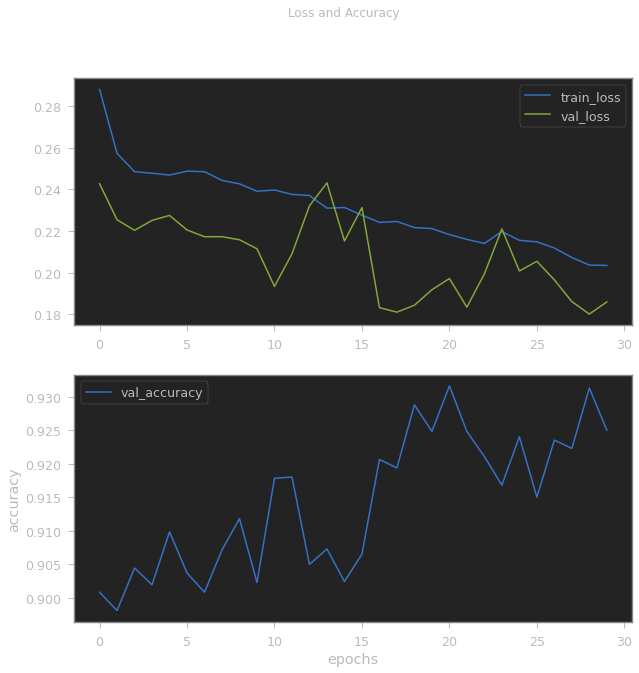

In [38]:
plot_loss_acc(history)

In [39]:
# # Load the latest model data_dir
# model.load_state_dict(torch.load('./UNET_1_BCE.pt'))
# metrics = eval_loop(model, criterion, val_loader)
# print('accuracy:', metrics['accuracy'])
# print('f1 macro:', metrics['f1_macro'])
# print('test loss:', metrics['loss'])

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize Training Results</center></h2>

Inspired by:

[Ant 🐜 ](https://www.kaggle.com/superant/simple-nn-segmentation/notebook)

In [40]:
def get_threshold(Y, pred):
    '''Function is called for finding threshols and IoU
    '''
    scores = list(pred.ravel())
    mask = list(Y.ravel())
    
    #idx from the end to the begining
    idxs=np.argsort(scores)[::-1]
    mask_sorted=np.array(mask)[idxs]
    sum_mask_one=np.cumsum(mask_sorted)
    IoU=sum_mask_one/(np.arange(1,len(mask_sorted)+1)+np.sum(mask_sorted)-sum_mask_one)
    best_IoU_idx=IoU.argmax()
    best_threshold=scores[idxs[best_IoU_idx]]
    best_IoU=IoU[best_IoU_idx]

    return best_threshold, best_IoU

Re-assign val_loader with higher num of batches (for further plotting)

In [41]:
val_loader_plot = DataLoader(val_dataset,
                          batch_size=16,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=WORKERS,)

In [42]:
@torch.no_grad()
def get_best_threshold(model,loader,device=DEVICE,N=3):
    img_thresholds = []
    img_IoUs = []
    model.eval()
    
    for img, mask in tqdm(itertools.islice(loader, N), total=N):
        img = img.to(device)
        mask = mask.detach().numpy()
        
        Y_hat = torch.sigmoid(model(img)).cpu().detach().numpy()
        
        for i in range(mask.shape[0]):
            best_img_threshold, best_img_IoU = get_threshold(mask[i], Y_hat[i])
            img_thresholds.append(best_img_threshold)
            img_IoUs.append(best_img_IoU)
            
    return img_thresholds,img_IoUs

In [43]:
img_thresholds,img_IoUs = get_best_threshold(model,val_loader_plot)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.07s/it]


In [44]:
best_threshold = np.mean(img_thresholds)
threshold_std = np.std(img_thresholds)
avg_IoU = np.mean(img_IoUs)

print(f"Best threshold: {best_threshold:.3g} (STD: +-{threshold_std:.3g}), Avg. Val IoU: {avg_IoU:.3f}")

Best threshold: 0.268 (STD: +-0.126), Avg. Val IoU: 0.499


In [45]:
threshold = best_threshold
model.eval()

X, Y = next(iter(val_loader_plot))
X = X.to(DEVICE)
Y = Y.detach().numpy()

with torch.no_grad():
    pred=torch.sigmoid(model(X)).cpu().detach().numpy()
    
pred_Y = (pred >= threshold)

In [46]:
def plot(Y_val, Y_hat):
    output = np.zeros_like(Y_val)
    output = np.where((Y_val == 0) & (Y_hat == 1), 1, output)
    output = np.where((Y_val == 1) & (Y_hat == 0), 2, output)
    output = np.where((Y_val == 1) & (Y_hat == 1), 3, output)

    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 15),)
#     ax1.imshow(np.rollaxis(Y_val, 0, 3),cmap='gray')
    ax1.imshow(Y_val,cmap='gray')
    ax2.imshow(((Y_hat * 255)), cmap='gray')
    ax3.imshow(output, cmap=cmap)
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    ax1.set_title('Real')
    ax2.set_title('Output')
    ax3.set_title('Real+Output')
    plt.xticks([])
    plt.yticks([]);

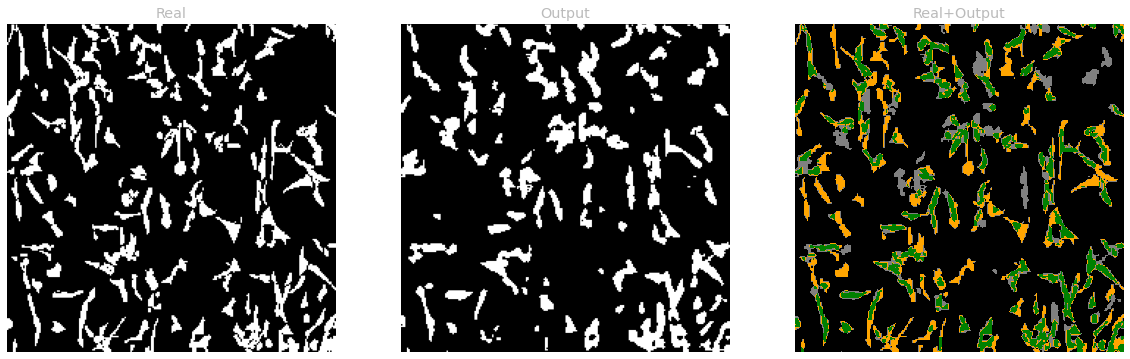

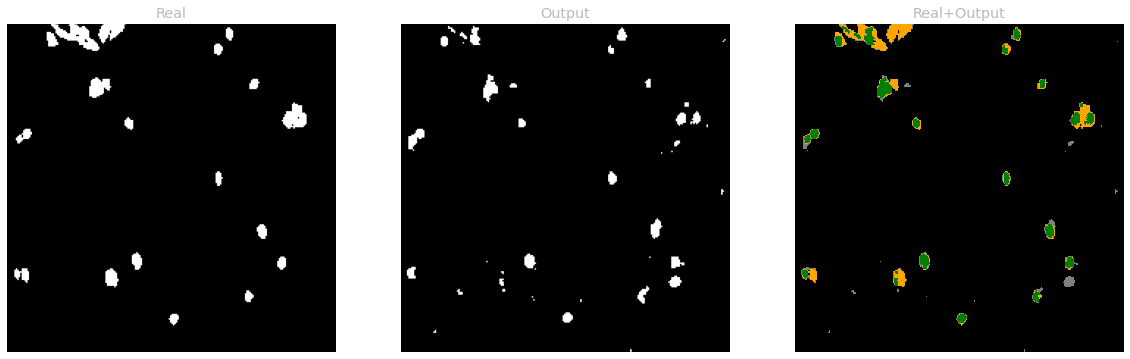

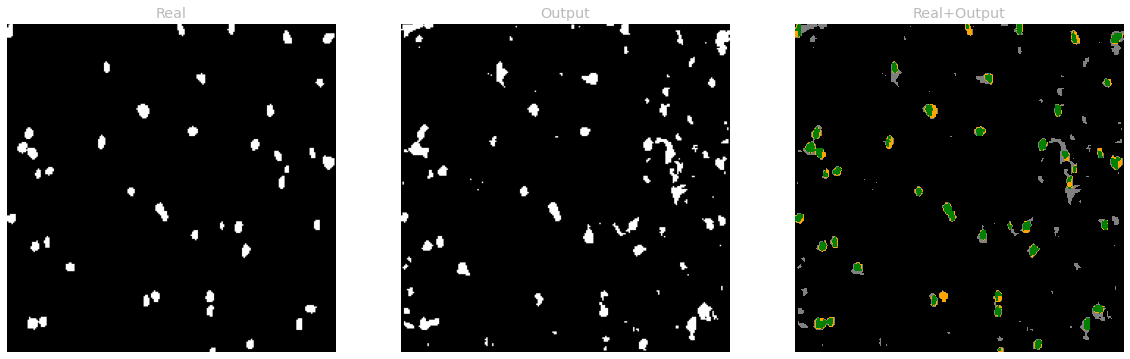

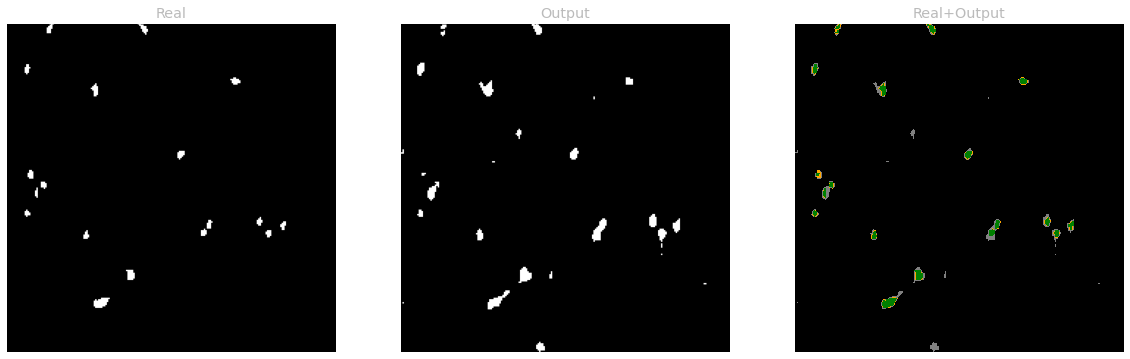

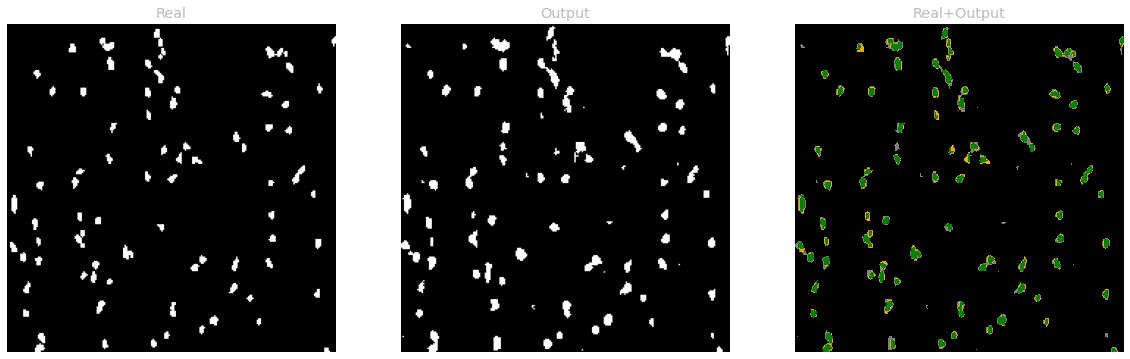

In [47]:
N = 5
for i in range(N):
    img_Y = Y[i, 0]
    img_pred = pred_Y[i, 0]
    
    plot(img_Y, img_pred)
    plt.show()

# green: correct prediction
# gray: false positive (too much)
# orange: false negative (missed)

In the plot 'real'

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Save Training Results to Pandas </center></h2>

Finaly, save all scores into a pandas dataframe

In [48]:
def get_scores(report_df, history, 
               name,loss_name, img_IoUs, 
               img_thresholds):
    '''Create and add metrics into a pandas DF after experiment'''
    train_loss, val_loss, val_acc, f1_macro = zip(*history)

    report = pd.DataFrame(columns={'Validation_loss'}, data=[0])
    report['Criterion'] = loss_name
    report['Validation_loss'] = val_loss[-1]
    report['Val_Acc_at_last_epoch'] = val_acc[-1]
    report['Mean_acc_in_val_set'] = np.mean(val_acc)
    report['F1_macro'] = f1_macro[-1]
    report['mean_F1_along_epochs'] = np.mean(f1_macro)
    report['Average_Val_IoU'] = np.mean(img_IoUs)
    report['Best_threshold'] = np.mean(img_thresholds)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [49]:
df_report = pd.DataFrame(data=None)

In [50]:
df_report = get_scores(df_report, history, 'Unet_BaseLine', 'BCE',
                      img_IoUs,img_thresholds)
df_report

Validation_loss Criterion  Val_Acc_at_last_epoch  \
Unet_BaseLine         0.185918       BCE               0.925013   

               Mean_acc_in_val_set  F1_macro  mean_F1_along_epochs  \
Unet_BaseLine             0.914239  0.452461              0.360788   

               Average_Val_IoU  Best_threshold  
Unet_BaseLine         0.499487        0.268031

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Jaccard Loss </center></h2>

In [51]:
# JaccardLoss = smp.losses.JaccardLoss(mode='binary') 
# #Jaccard     = smp.losses.JaccardLoss(mode='binary', from_logits=False)
# Dice        = smp.losses.DiceLoss(mode='binary')
# BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

In [52]:
del model
torch.cuda.empty_cache()
model = UNet(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY )
criterion = JaccardLoss

In [53]:
history = train(model, optimizer, criterion, train_loader, val_loader, model_name='UNET_1_Jaccard.pt')

Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 1 TrainLoss: 0.80243 ValidLoss: 0.72651 ACC: 0.87074 F1: 0.441


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 2 TrainLoss: 0.74447 ValidLoss: 0.65683 ACC: 0.91543 F1: 0.509


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 3 TrainLoss: 0.71264 ValidLoss: 0.65887 ACC: 0.91324 F1: 0.506


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.81s/it]


Epoch: 4 TrainLoss: 0.68726 ValidLoss: 0.60917 ACC: 0.92344 F1: 0.559


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 5 TrainLoss: 0.67057 ValidLoss: 0.61511 ACC: 0.90789 F1: 0.551


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 6 TrainLoss: 0.66270 ValidLoss: 0.56909 ACC: 0.92358 F1: 0.604


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 7 TrainLoss: 0.65943 ValidLoss: 0.55190 ACC: 0.93171 F1: 0.620


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 8 TrainLoss: 0.64645 ValidLoss: 0.54634 ACC: 0.93226 F1: 0.623


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 9 TrainLoss: 0.63880 ValidLoss: 0.52721 ACC: 0.93342 F1: 0.640


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 10 TrainLoss: 0.63483 ValidLoss: 0.59772 ACC: 0.92862 F1: 0.563


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 11 TrainLoss: 0.62686 ValidLoss: 0.56514 ACC: 0.92256 F1: 0.605


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 12 TrainLoss: 0.62479 ValidLoss: 0.53911 ACC: 0.93345 F1: 0.627


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 13 TrainLoss: 0.62121 ValidLoss: 0.55929 ACC: 0.92537 F1: 0.613


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 14 TrainLoss: 0.61329 ValidLoss: 0.53977 ACC: 0.92818 F1: 0.633


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 15 TrainLoss: 0.60893 ValidLoss: 0.56442 ACC: 0.92337 F1: 0.606


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 16 TrainLoss: 0.59733 ValidLoss: 0.59210 ACC: 0.90829 F1: 0.578


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 17 TrainLoss: 0.58202 ValidLoss: 0.52085 ACC: 0.92924 F1: 0.647


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.83s/it]


Epoch: 18 TrainLoss: 0.57515 ValidLoss: 0.53177 ACC: 0.92892 F1: 0.638


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 19 TrainLoss: 0.57713 ValidLoss: 0.50327 ACC: 0.93632 F1: 0.661


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:59<00:00,  1.91s/it]


Epoch: 20 TrainLoss: 0.56616 ValidLoss: 0.51414 ACC: 0.93209 F1: 0.652


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 21 TrainLoss: 0.55207 ValidLoss: 0.52959 ACC: 0.92979 F1: 0.640


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 22 TrainLoss: 0.55118 ValidLoss: 0.51368 ACC: 0.93126 F1: 0.652


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 23 TrainLoss: 0.54186 ValidLoss: 0.51328 ACC: 0.93544 F1: 0.650


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 24 TrainLoss: 0.54062 ValidLoss: 0.50706 ACC: 0.93211 F1: 0.659


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 25 TrainLoss: 0.53848 ValidLoss: 0.50307 ACC: 0.93308 F1: 0.663


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 26 TrainLoss: 0.54297 ValidLoss: 0.54133 ACC: 0.92002 F1: 0.631


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 27 TrainLoss: 0.53399 ValidLoss: 0.52498 ACC: 0.92779 F1: 0.644


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 28 TrainLoss: 0.53438 ValidLoss: 0.49747 ACC: 0.93559 F1: 0.665


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 29 TrainLoss: 0.53067 ValidLoss: 0.49838 ACC: 0.93490 F1: 0.665


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]

Epoch: 30 TrainLoss: 0.53672 ValidLoss: 0.53584 ACC: 0.92766 F1: 0.633


In [54]:
img_thresholds,img_IoUs = get_best_threshold(model,val_loader_plot)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:59<00:00, 19.76s/it]


In [55]:
best_threshold = np.mean(img_thresholds)
threshold_std = np.std(img_thresholds)
avg_IoU = np.mean(img_IoUs)

print(f"Best threshold: {best_threshold:.3g} (STD: +-{threshold_std:.3g}), Avg. Val IoU: {avg_IoU:.3f}")

Best threshold: 0.749 (STD: +-0.382), Avg. Val IoU: 0.545


In [56]:
threshold = best_threshold
model.eval()

X, Y = next(iter(val_loader_plot))
X = X.to(DEVICE)
Y = Y.detach().numpy()

with torch.no_grad():
    pred=torch.sigmoid(model(X)).cpu().detach().numpy()
    
pred_Y = (pred >= threshold)

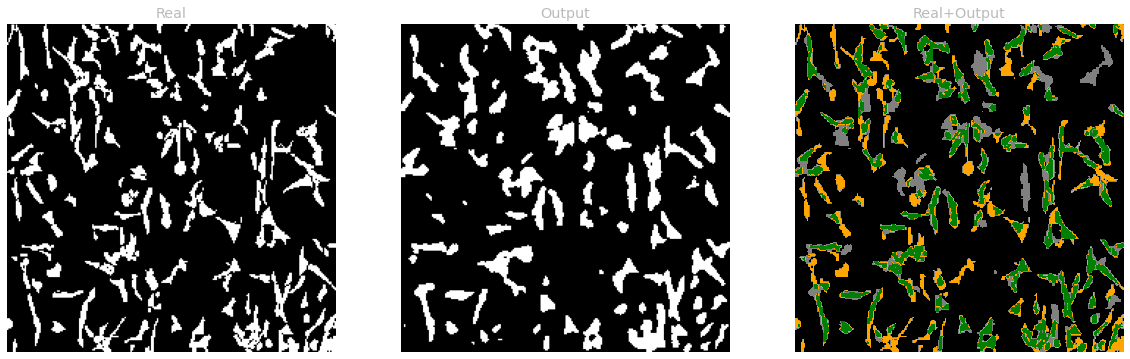

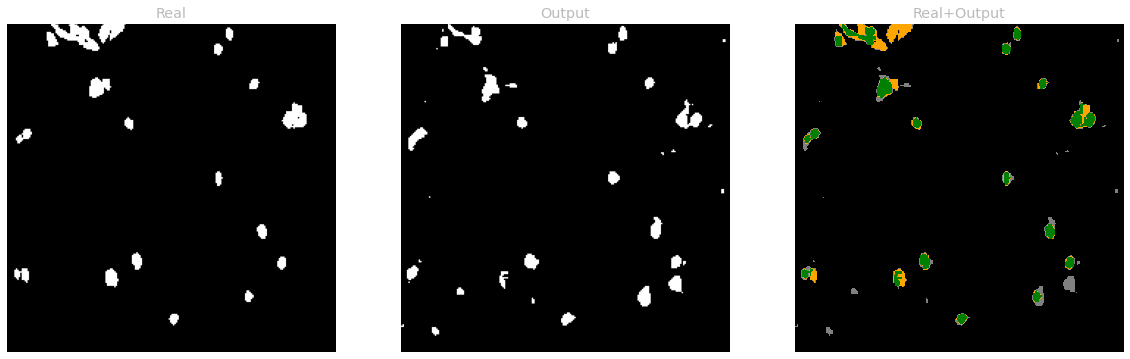

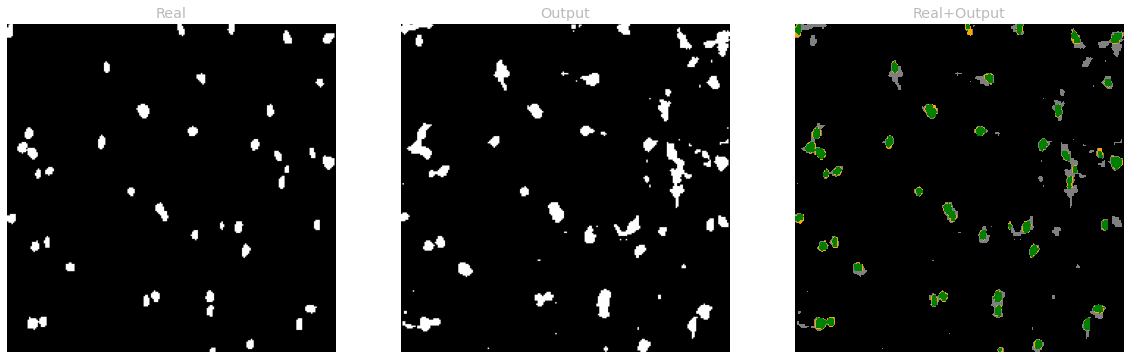

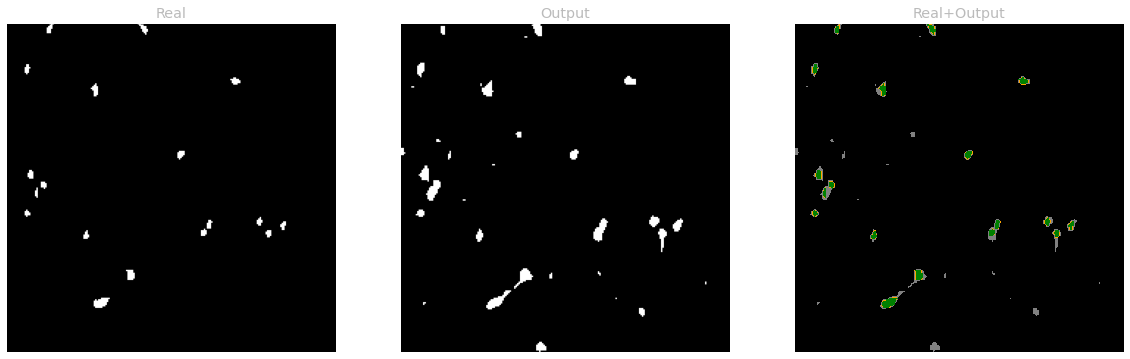

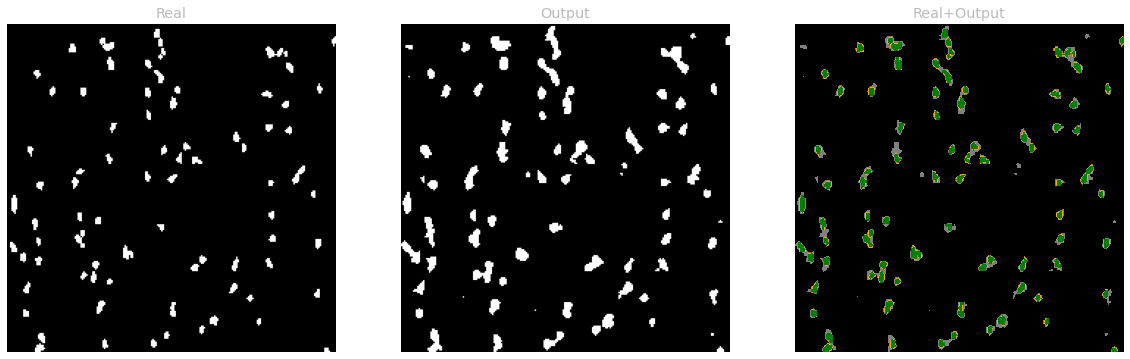

In [57]:
N = 5
for i in range(N):
    img_Y = Y[i, 0]
    img_pred = pred_Y[i, 0]
    
    plot(img_Y, img_pred)
    plt.show()

# green: correct prediction
# gray: false positive (too much)
# orange: false negative (missed)

In [58]:
df_report = get_scores(df_report, history, 'Unet_BaseLine',
                       "JaccardLoss_mode_binary",img_IoUs,img_thresholds
                      )
df_report

Validation_loss                Criterion  \
Unet_BaseLine         0.185918                      BCE   
Unet_BaseLine         0.535844  JaccardLoss_mode_binary   

               Val_Acc_at_last_epoch  Mean_acc_in_val_set  F1_macro  \
Unet_BaseLine               0.925013             0.914239  0.452461   
Unet_BaseLine               0.927658             0.925191  0.633374   

               mean_F1_along_epochs  Average_Val_IoU  Best_threshold  
Unet_BaseLine              0.360788         0.499487        0.268031  
Unet_BaseLine              0.612641         0.544788        0.749460

CONCLUSIONS !!!!

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Dice Loss </center></h2>

In [59]:
del model
torch.cuda.empty_cache()
model = UNet(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY )
criterion = Dice

In [60]:
history = train(model, optimizer, criterion, train_loader, val_loader, model_name='UNET_1_Dice.pt')

Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.81s/it]


Epoch: 1 TrainLoss: 0.67890 ValidLoss: 0.57343 ACC: 0.88349 F1: 0.439


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 2 TrainLoss: 0.59960 ValidLoss: 0.59520 ACC: 0.91213 F1: 0.391


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 3 TrainLoss: 0.55064 ValidLoss: 0.42269 ACC: 0.92666 F1: 0.586


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 4 TrainLoss: 0.52978 ValidLoss: 0.44821 ACC: 0.92381 F1: 0.555


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.83s/it]


Epoch: 5 TrainLoss: 0.51844 ValidLoss: 0.39822 ACC: 0.92775 F1: 0.611


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 6 TrainLoss: 0.50884 ValidLoss: 0.40604 ACC: 0.92941 F1: 0.596


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 7 TrainLoss: 0.50363 ValidLoss: 0.40796 ACC: 0.92532 F1: 0.603


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 8 TrainLoss: 0.49198 ValidLoss: 0.42415 ACC: 0.91603 F1: 0.585


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 9 TrainLoss: 0.47949 ValidLoss: 0.37654 ACC: 0.92519 F1: 0.632


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 10 TrainLoss: 0.47446 ValidLoss: 0.40613 ACC: 0.92295 F1: 0.605


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 11 TrainLoss: 0.47277 ValidLoss: 0.37510 ACC: 0.93382 F1: 0.630


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 12 TrainLoss: 0.46768 ValidLoss: 0.37914 ACC: 0.93094 F1: 0.626


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 13 TrainLoss: 0.45971 ValidLoss: 0.37297 ACC: 0.93245 F1: 0.629


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 14 TrainLoss: 0.45792 ValidLoss: 0.35517 ACC: 0.93325 F1: 0.650


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 15 TrainLoss: 0.44835 ValidLoss: 0.35987 ACC: 0.93110 F1: 0.645


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 16 TrainLoss: 0.44623 ValidLoss: 0.36528 ACC: 0.92683 F1: 0.641


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 17 TrainLoss: 0.43035 ValidLoss: 0.36096 ACC: 0.93529 F1: 0.641


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 18 TrainLoss: 0.41535 ValidLoss: 0.36339 ACC: 0.92886 F1: 0.644


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 19 TrainLoss: 0.39888 ValidLoss: 0.37591 ACC: 0.93642 F1: 0.622


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 20 TrainLoss: 0.39123 ValidLoss: 0.34082 ACC: 0.93446 F1: 0.662


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 21 TrainLoss: 0.38423 ValidLoss: 0.36820 ACC: 0.92726 F1: 0.642


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 22 TrainLoss: 0.38615 ValidLoss: 0.34704 ACC: 0.92969 F1: 0.656


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 23 TrainLoss: 0.38211 ValidLoss: 0.37125 ACC: 0.93342 F1: 0.630


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 24 TrainLoss: 0.37772 ValidLoss: 0.34610 ACC: 0.93384 F1: 0.659


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 25 TrainLoss: 0.37763 ValidLoss: 0.34993 ACC: 0.93584 F1: 0.652


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 26 TrainLoss: 0.36708 ValidLoss: 0.35277 ACC: 0.92796 F1: 0.654


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 27 TrainLoss: 0.36553 ValidLoss: 0.34642 ACC: 0.93309 F1: 0.658


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 28 TrainLoss: 0.36857 ValidLoss: 0.34712 ACC: 0.93023 F1: 0.658


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 29 TrainLoss: 0.36601 ValidLoss: 0.35583 ACC: 0.92796 F1: 0.653


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]

Epoch: 30 TrainLoss: 0.36656 ValidLoss: 0.36461 ACC: 0.93452 F1: 0.636


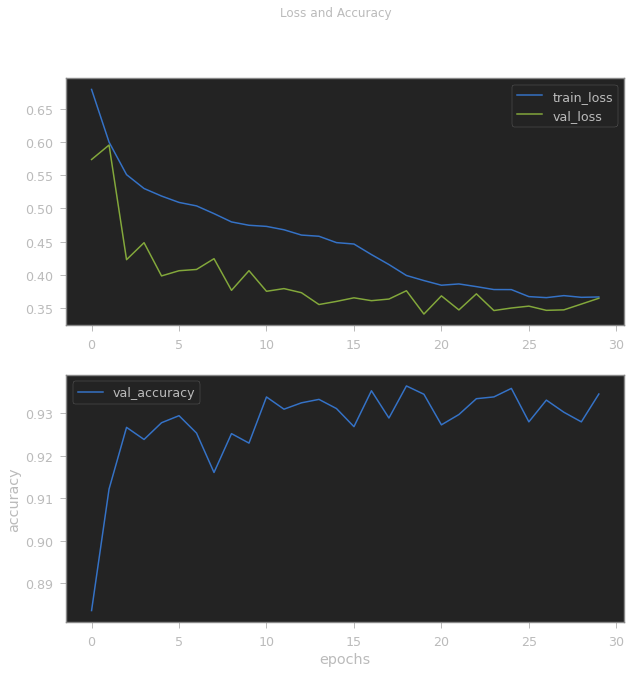

In [61]:
plot_loss_acc(history)

In [62]:
img_thresholds,img_IoUs = get_best_threshold(model,val_loader_plot)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.03s/it]


In [63]:
best_threshold = np.mean(img_thresholds)
threshold_std = np.std(img_thresholds)
avg_IoU = np.mean(img_IoUs)

print(f"Best threshold: {best_threshold:.3g} (STD: +-{threshold_std:.3g}), Avg. Val IoU: {avg_IoU:.3f}")

Best threshold: 0.231 (STD: +-0.328), Avg. Val IoU: 0.514


In [64]:
threshold = best_threshold
model.eval()

X, Y = next(iter(val_loader_plot))
X = X.to(DEVICE)
Y = Y.detach().numpy()

with torch.no_grad():
    pred=torch.sigmoid(model(X)).cpu().detach().numpy()
    
pred_Y = (pred >= threshold)

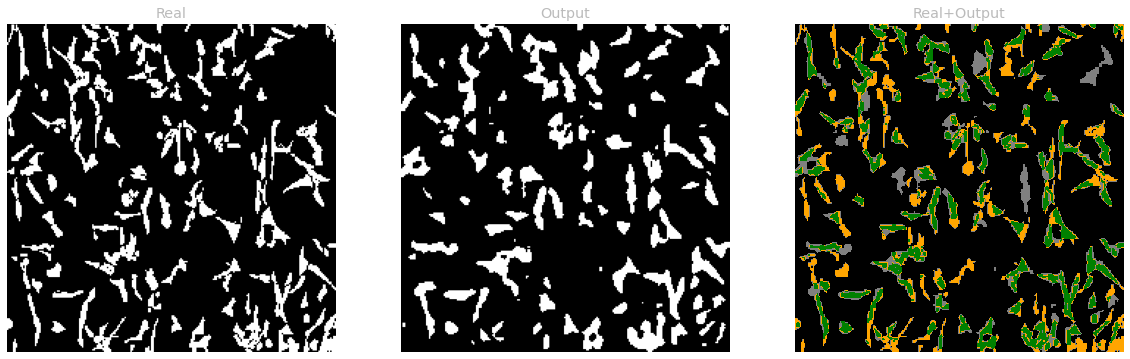

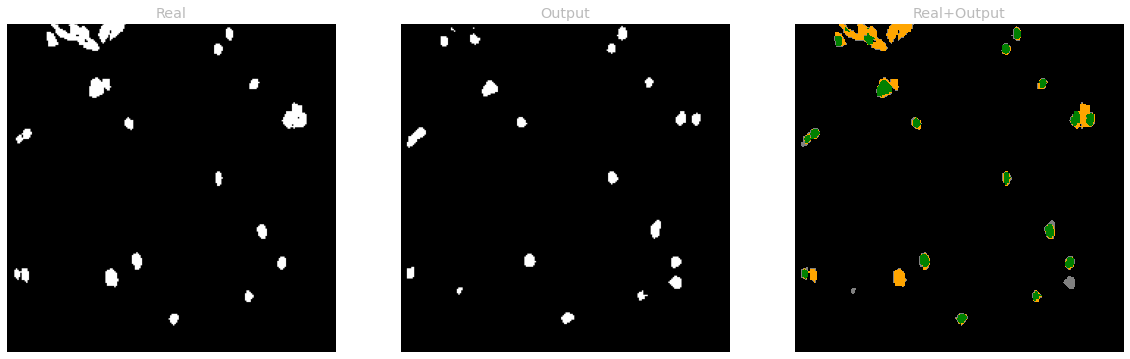

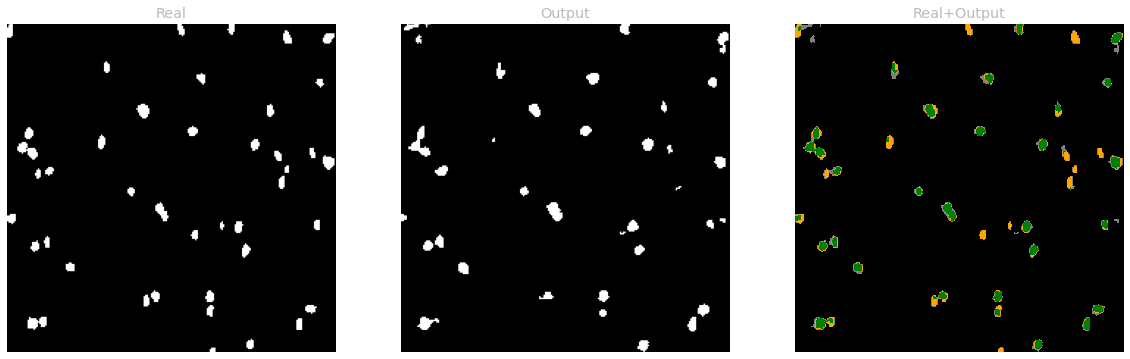

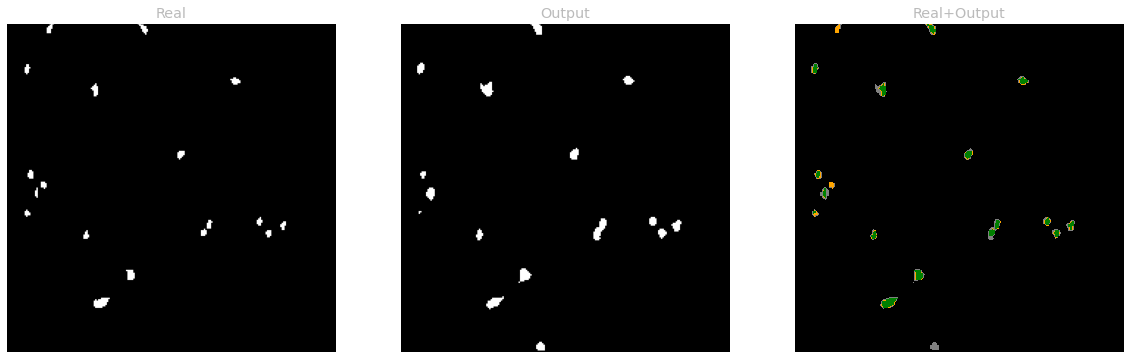

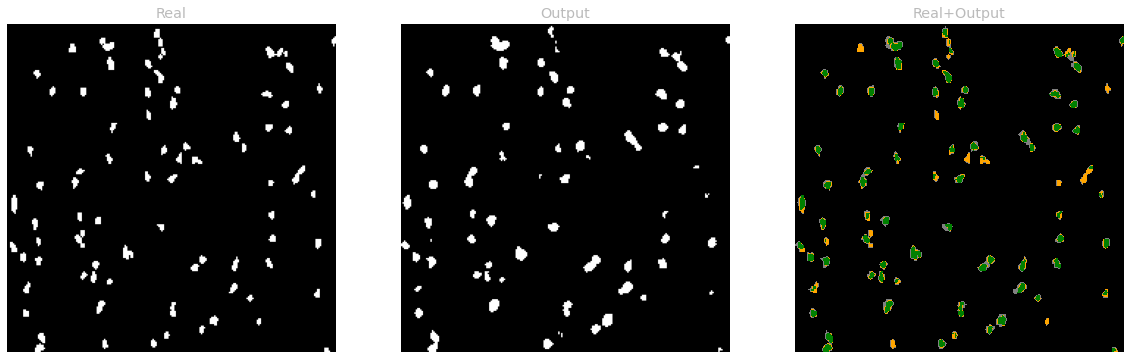

In [65]:
N = 5
for i in range(N):
    img_Y = Y[i, 0]
    img_pred = pred_Y[i, 0]
    
    plot(img_Y, img_pred)
    plt.show()

# green: correct prediction
# gray: false positive (too much)
# orange: false negative (missed)

In [66]:
df_report = get_scores(df_report, history, 'Unet_BaseLine',
                       "Dice",img_IoUs,img_thresholds
                      )
df_report

Validation_loss                Criterion  \
Unet_BaseLine         0.185918                      BCE   
Unet_BaseLine         0.535844  JaccardLoss_mode_binary   
Unet_BaseLine         0.364606                     Dice   

               Val_Acc_at_last_epoch  Mean_acc_in_val_set  F1_macro  \
Unet_BaseLine               0.925013             0.914239  0.452461   
Unet_BaseLine               0.927658             0.925191  0.633374   
Unet_BaseLine               0.934521             0.927666  0.635706   

               mean_F1_along_epochs  Average_Val_IoU  Best_threshold  
Unet_BaseLine              0.360788         0.499487        0.268031  
Unet_BaseLine              0.612641         0.544788        0.749460  
Unet_BaseLine              0.616218         0.513575        0.230654

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>ComboLoss </center></h2>

In [67]:
from Losses import ComboLoss

In [68]:
del model
torch.cuda.empty_cache()
model = UNet(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY )
criterion        = ComboLoss(**{'weights':{'dice':3, 'focal':2, 'jaccard':3}})

In [69]:
history = train(model, optimizer, criterion, train_loader, val_loader, model_name='UNET_1_ComboLoss.pt')

Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 1 TrainLoss: 4.74359 ValidLoss: 3.92097 ACC: 0.92644 F1: 0.552


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 2 TrainLoss: 4.35181 ValidLoss: 3.79673 ACC: 0.92587 F1: 0.582


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 3 TrainLoss: 4.21165 ValidLoss: 4.25453 ACC: 0.88058 F1: 0.510


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 4 TrainLoss: 4.16918 ValidLoss: 3.81101 ACC: 0.91129 F1: 0.575


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:54<00:00,  1.77s/it]


Epoch: 5 TrainLoss: 4.12572 ValidLoss: 3.52795 ACC: 0.92333 F1: 0.613


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 6 TrainLoss: 4.05712 ValidLoss: 3.49056 ACC: 0.92575 F1: 0.624


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:54<00:00,  1.77s/it]


Epoch: 7 TrainLoss: 3.99177 ValidLoss: 3.64571 ACC: 0.92962 F1: 0.598


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 8 TrainLoss: 3.94493 ValidLoss: 3.20976 ACC: 0.93359 F1: 0.651


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 9 TrainLoss: 3.89739 ValidLoss: 3.34896 ACC: 0.92847 F1: 0.651


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 10 TrainLoss: 3.79744 ValidLoss: 3.88494 ACC: 0.92345 F1: 0.512


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 11 TrainLoss: 3.71312 ValidLoss: 3.38462 ACC: 0.93308 F1: 0.605


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 12 TrainLoss: 3.67393 ValidLoss: 3.67392 ACC: 0.92968 F1: 0.579


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 13 TrainLoss: 3.54949 ValidLoss: 3.32550 ACC: 0.93594 F1: 0.618


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 14 TrainLoss: 3.53019 ValidLoss: 3.24588 ACC: 0.93491 F1: 0.651


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 15 TrainLoss: 3.48841 ValidLoss: 2.97544 ACC: 0.93914 F1: 0.669


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 16 TrainLoss: 3.43712 ValidLoss: 3.01599 ACC: 0.93531 F1: 0.675


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:54<00:00,  1.77s/it]


Epoch: 17 TrainLoss: 3.40454 ValidLoss: 2.94547 ACC: 0.93721 F1: 0.680


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 18 TrainLoss: 3.30909 ValidLoss: 2.97940 ACC: 0.93956 F1: 0.669


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 19 TrainLoss: 3.28338 ValidLoss: 3.15244 ACC: 0.93910 F1: 0.645


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 20 TrainLoss: 3.30690 ValidLoss: 3.09480 ACC: 0.93722 F1: 0.648


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 21 TrainLoss: 3.25873 ValidLoss: 3.26907 ACC: 0.93251 F1: 0.646


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 22 TrainLoss: 3.29290 ValidLoss: 3.22990 ACC: 0.93205 F1: 0.653


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 23 TrainLoss: 3.25114 ValidLoss: 3.12075 ACC: 0.93399 F1: 0.658


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 24 TrainLoss: 3.21898 ValidLoss: 3.03578 ACC: 0.93637 F1: 0.671


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 25 TrainLoss: 3.13227 ValidLoss: 3.14616 ACC: 0.93118 F1: 0.657


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 26 TrainLoss: 3.20761 ValidLoss: 3.07806 ACC: 0.93504 F1: 0.663


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 27 TrainLoss: 3.18978 ValidLoss: 3.26903 ACC: 0.93288 F1: 0.658


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 28 TrainLoss: 3.15348 ValidLoss: 2.99556 ACC: 0.93936 F1: 0.670


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:54<00:00,  1.77s/it]


Epoch: 29 TrainLoss: 3.15663 ValidLoss: 3.11067 ACC: 0.93160 F1: 0.667


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]

Epoch: 30 TrainLoss: 3.09945 ValidLoss: 3.14204 ACC: 0.93420 F1: 0.666


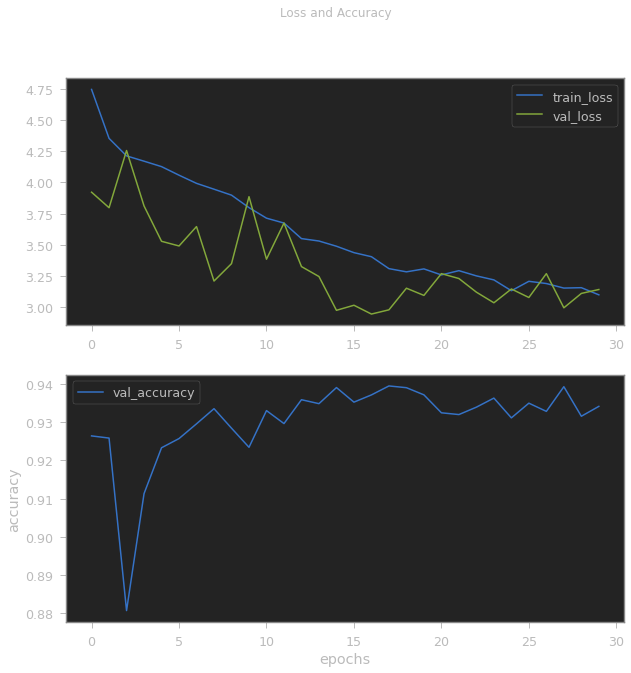

In [70]:
plot_loss_acc(history)

In [71]:
img_thresholds,img_IoUs = get_best_threshold(model,val_loader_plot)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.29s/it]


In [72]:
best_threshold = np.mean(img_thresholds)
threshold_std = np.std(img_thresholds)
avg_IoU = np.mean(img_IoUs)

print(f"Best threshold: {best_threshold:.3g} (STD: +-{threshold_std:.3g}), Avg. Val IoU: {avg_IoU:.3f}")

Best threshold: 0.653 (STD: +-0.268), Avg. Val IoU: 0.546


In [73]:
threshold = best_threshold
model.eval()

X, Y = next(iter(val_loader_plot))
X = X.to(DEVICE)
Y = Y.detach().numpy()

with torch.no_grad():
    pred=torch.sigmoid(model(X)).cpu().detach().numpy()
    
pred_Y = (pred >= threshold)

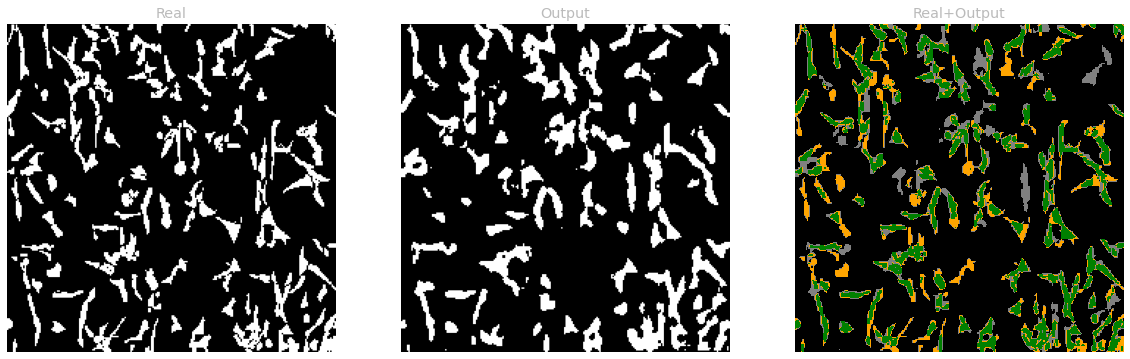

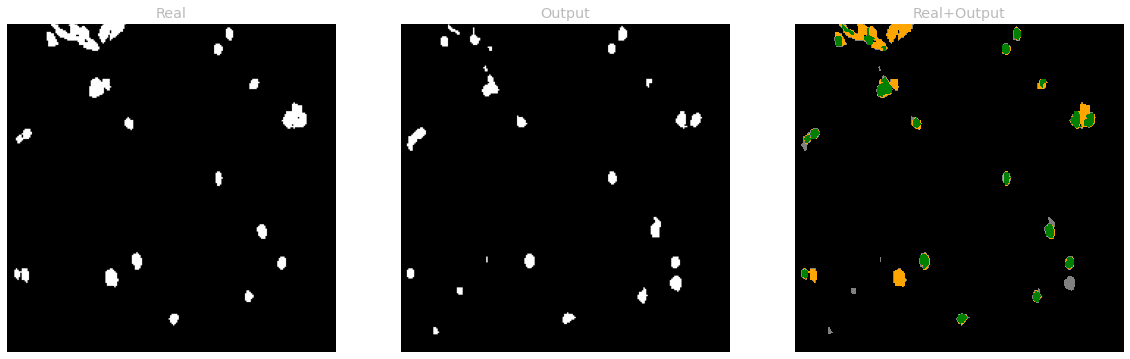

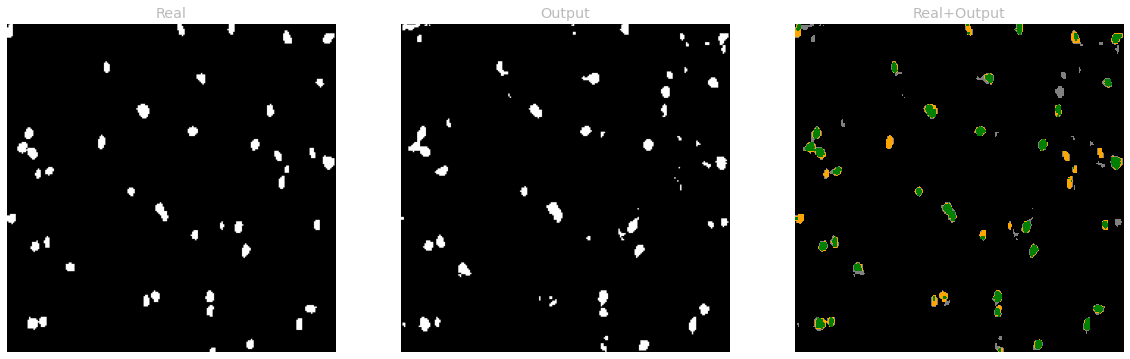

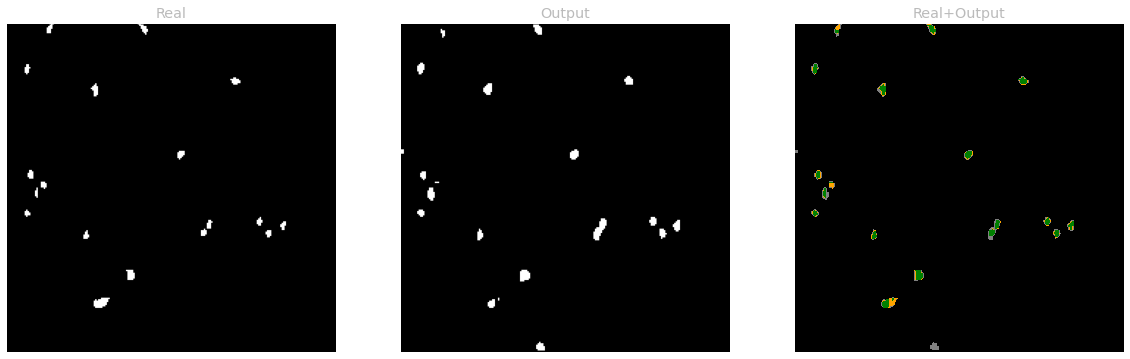

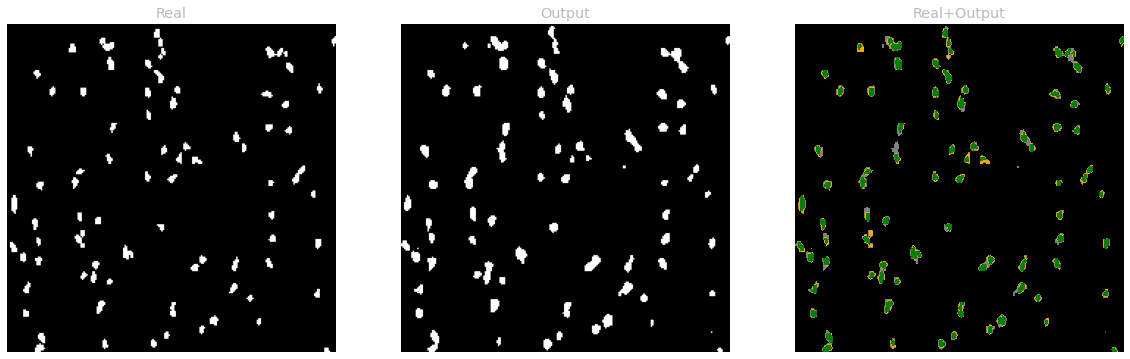

In [74]:
N = 5
for i in range(N):
    img_Y = Y[i, 0]
    img_pred = pred_Y[i, 0]
    
    plot(img_Y, img_pred)
    plt.show()

# green: correct prediction
# gray: false positive (too much)
# orange: false negative (missed)

In [75]:
df_report = get_scores(df_report, history, 'Unet_BaseLine',
                       "ComboLoss",img_IoUs,img_thresholds
                      )
df_report

Validation_loss                Criterion  \
Unet_BaseLine         0.185918                      BCE   
Unet_BaseLine         0.535844  JaccardLoss_mode_binary   
Unet_BaseLine         0.364606                     Dice   
Unet_BaseLine         3.142038                ComboLoss   

               Val_Acc_at_last_epoch  Mean_acc_in_val_set  F1_macro  \
Unet_BaseLine               0.925013             0.914239  0.452461   
Unet_BaseLine               0.927658             0.925191  0.633374   
Unet_BaseLine               0.934521             0.927666  0.635706   
Unet_BaseLine               0.934198             0.930291  0.666040   

               mean_F1_along_epochs  Average_Val_IoU  Best_threshold  
Unet_BaseLine              0.360788         0.499487        0.268031  
Unet_BaseLine              0.612641         0.544788        0.749460  
Unet_BaseLine              0.616218         0.513575        0.230654  
Unet_BaseLine              0.630492         0.546431        0.653479

# Unet from Segmentation Models

https://github.com/qubvel/segmentation_models.pytorch#installation

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [ ]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [76]:
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None

In [77]:
del model
torch.cuda.empty_cache()

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY )
criterion        = ComboLoss(**{'weights':{'dice':3, 'focal':2, 'jaccard':3}})

In [78]:
history = train(model, optimizer, criterion, train_loader, val_loader, model_name='UNET_2_Combo.pt')

Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:57<00:00,  1.84s/it]


Epoch: 1 TrainLoss: 4.55397 ValidLoss: 3.94861 ACC: 0.87396 F1: 0.569


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 2 TrainLoss: 4.04965 ValidLoss: 3.58901 ACC: 0.91527 F1: 0.585


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 3 TrainLoss: 3.76312 ValidLoss: 3.25039 ACC: 0.93149 F1: 0.626


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 4 TrainLoss: 3.44836 ValidLoss: 3.35209 ACC: 0.91234 F1: 0.639


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 5 TrainLoss: 3.32185 ValidLoss: 3.29487 ACC: 0.91517 F1: 0.645


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 6 TrainLoss: 3.23940 ValidLoss: 3.46829 ACC: 0.89976 F1: 0.628


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 7 TrainLoss: 3.17541 ValidLoss: 3.13635 ACC: 0.91946 F1: 0.658


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 8 TrainLoss: 3.18554 ValidLoss: 3.23217 ACC: 0.91272 F1: 0.649


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 9 TrainLoss: 3.10031 ValidLoss: 3.39027 ACC: 0.89734 F1: 0.629


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 10 TrainLoss: 3.09429 ValidLoss: 3.21218 ACC: 0.91615 F1: 0.648


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 11 TrainLoss: 3.06748 ValidLoss: 3.39302 ACC: 0.89618 F1: 0.630


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 12 TrainLoss: 3.04664 ValidLoss: 3.20872 ACC: 0.91690 F1: 0.653


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 13 TrainLoss: 3.04521 ValidLoss: 3.26462 ACC: 0.91049 F1: 0.642


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 14 TrainLoss: 3.02380 ValidLoss: 3.29197 ACC: 0.91031 F1: 0.643


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 15 TrainLoss: 2.99929 ValidLoss: 3.44449 ACC: 0.89779 F1: 0.629


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 16 TrainLoss: 2.99050 ValidLoss: 3.15799 ACC: 0.91481 F1: 0.657


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.83s/it]


Epoch: 17 TrainLoss: 3.02407 ValidLoss: 3.27863 ACC: 0.91119 F1: 0.646


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 18 TrainLoss: 3.03266 ValidLoss: 3.62715 ACC: 0.89579 F1: 0.626


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.82s/it]


Epoch: 19 TrainLoss: 2.95081 ValidLoss: 3.04746 ACC: 0.92602 F1: 0.670


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 20 TrainLoss: 2.95445 ValidLoss: 3.40928 ACC: 0.89873 F1: 0.638


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 21 TrainLoss: 2.97727 ValidLoss: 3.56648 ACC: 0.89221 F1: 0.626


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.78s/it]


Epoch: 22 TrainLoss: 2.94724 ValidLoss: 3.15173 ACC: 0.91263 F1: 0.662


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 23 TrainLoss: 2.92350 ValidLoss: 3.13615 ACC: 0.91732 F1: 0.667


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.79s/it]


Epoch: 24 TrainLoss: 2.91465 ValidLoss: 3.06968 ACC: 0.91860 F1: 0.671


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.83s/it]


Epoch: 25 TrainLoss: 2.88476 ValidLoss: 3.01630 ACC: 0.92377 F1: 0.677


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 26 TrainLoss: 2.89355 ValidLoss: 3.19107 ACC: 0.91711 F1: 0.659


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:57<00:00,  1.84s/it]


Epoch: 27 TrainLoss: 2.91023 ValidLoss: 3.28153 ACC: 0.89967 F1: 0.652


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]


Epoch: 28 TrainLoss: 2.87459 ValidLoss: 3.12876 ACC: 0.92007 F1: 0.662


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


Epoch: 29 TrainLoss: 2.87718 ValidLoss: 3.01838 ACC: 0.92756 F1: 0.676


Iterating over evaluation data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:56<00:00,  1.81s/it]

Epoch: 30 TrainLoss: 2.86652 ValidLoss: 3.16760 ACC: 0.91632 F1: 0.660


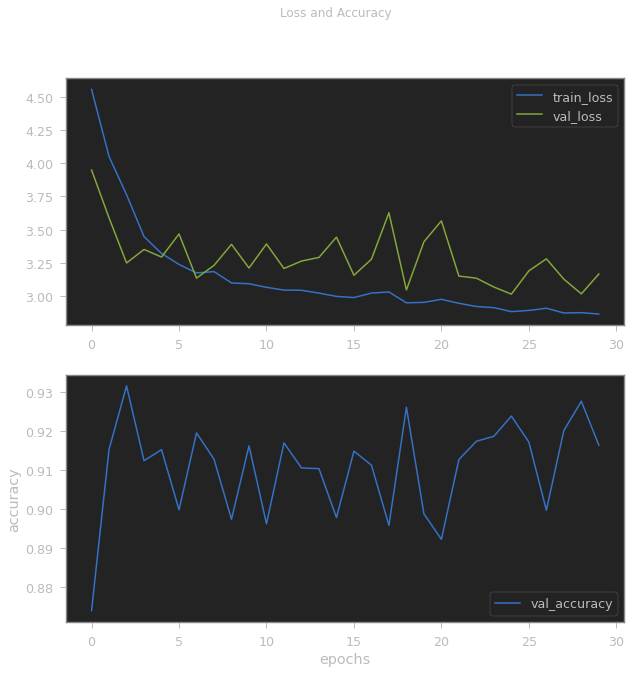

In [79]:
plot_loss_acc(history)

In [80]:
img_thresholds,img_IoUs = get_best_threshold(model,val_loader_plot)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.38s/it]


In [81]:
best_threshold = np.mean(img_thresholds)
threshold_std = np.std(img_thresholds)
avg_IoU = np.mean(img_IoUs)

print(f"Best threshold: {best_threshold:.3g} (STD: +-{threshold_std:.3g}), Avg. Val IoU: {avg_IoU:.3f}")

Best threshold: 0.754 (STD: +-0.247), Avg. Val IoU: 0.534


In [82]:
threshold = best_threshold
model.eval()

X, Y = next(iter(val_loader_plot))
X = X.to(DEVICE)
Y = Y.detach().numpy()

with torch.no_grad():
    pred=torch.sigmoid(model(X)).cpu().detach().numpy()
    
pred_Y = (pred >= threshold)

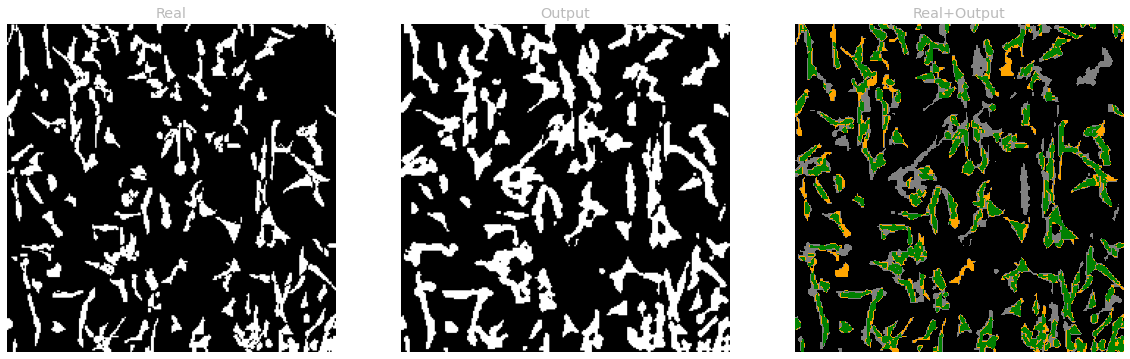

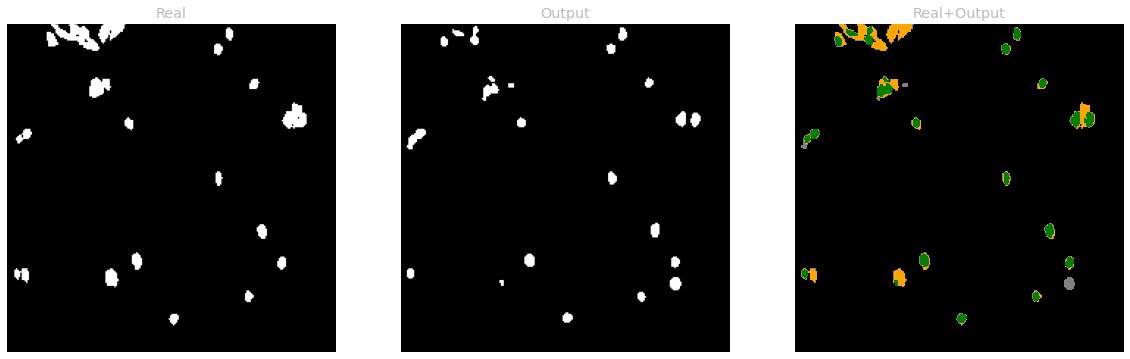

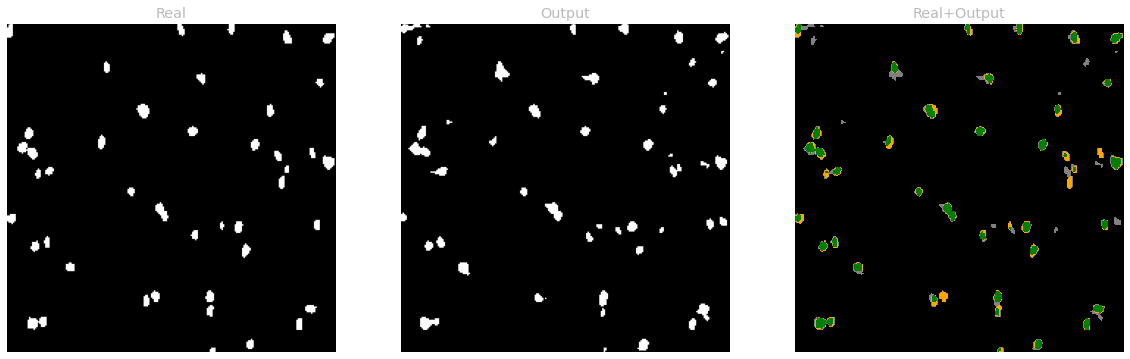

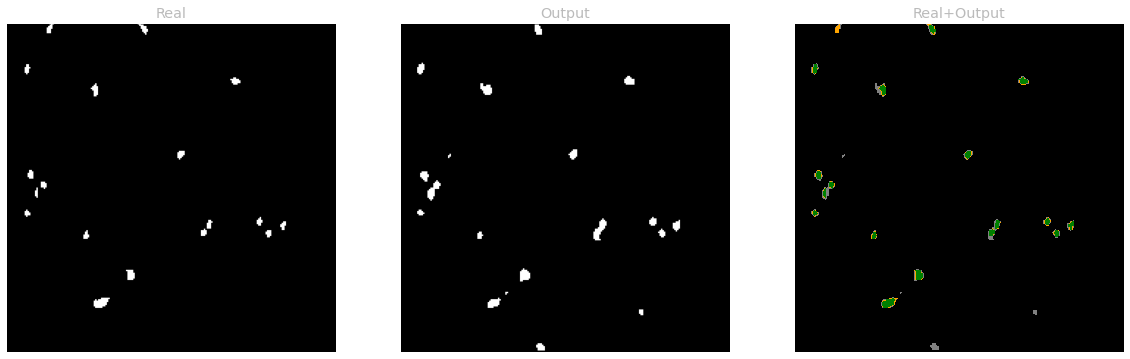

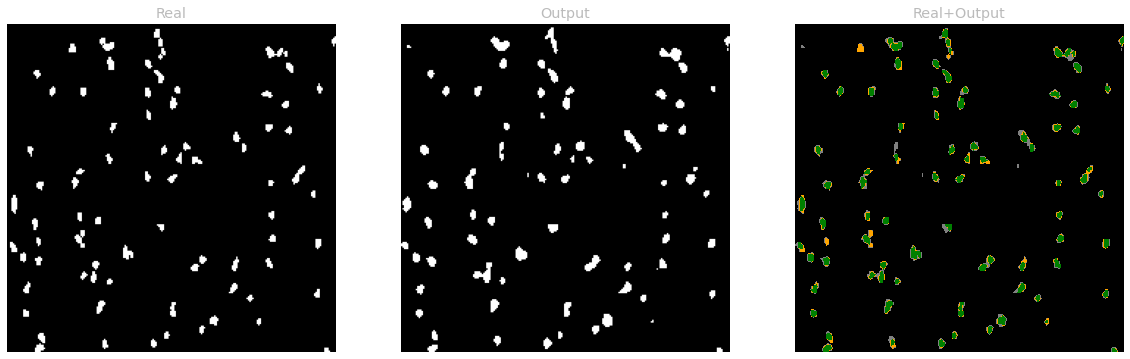

In [83]:
N = 5
for i in range(N):
    img_Y = Y[i, 0]
    img_pred = pred_Y[i, 0]
    
    plot(img_Y, img_pred)
    plt.show()

# green: correct prediction
# gray: false positive (too much)
# orange: false negative (missed)

In [84]:
df_report = get_scores(df_report, history, 'Unet_BaseLine',
                       "ComboLoss",img_IoUs,img_thresholds
                      )
df_report

Validation_loss                Criterion  \
Unet_BaseLine         0.185918                      BCE   
Unet_BaseLine         0.535844  JaccardLoss_mode_binary   
Unet_BaseLine         0.364606                     Dice   
Unet_BaseLine         3.142038                ComboLoss   
Unet_BaseLine         3.167599                ComboLoss   

               Val_Acc_at_last_epoch  Mean_acc_in_val_set  F1_macro  \
Unet_BaseLine               0.925013             0.914239  0.452461   
Unet_BaseLine               0.927658             0.925191  0.633374   
Unet_BaseLine               0.934521             0.927666  0.635706   
Unet_BaseLine               0.934198             0.930291  0.666040   
Unet_BaseLine               0.916316             0.910572  0.660098   

               mean_F1_along_epochs  Average_Val_IoU  Best_threshold  
Unet_BaseLine              0.360788         0.499487        0.268031  
Unet_BaseLine              0.612641         0.544788        0.749460  
Unet_BaseLine              0.616218         0.513575        0.230654  
Unet_BaseLine              0.630492         0.546431        0.653479  
Unet_BaseLine              0.644003         0.534376        0.754308